# Read in the data

### We will be looking at traffic infraction data and attempt to model and predict future traffic infractions

In [1]:
import pandas as pd
import pickle
import csv
import os

C:\Users\Todd\Anaconda2\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
with open('fines_per_day.pkl','rb') as file_:
    fines_per_day = pickle.load(file_)

In [167]:
with open('fines_with_holidays.pkl','wb') as file_:
    pickle.dump(fines_per_day,file_)

In [3]:
fines_per_day['date'] = fines_per_day.index

In [4]:
fines_per_day.columns = ['count','sum','date']

In [5]:
fines_per_day = fines_per_day.reset_index()

In [6]:
fines_per_day = fines_per_day.drop(['date_of_infraction'],axis=1)

In [7]:
fines_per_day['date']= pd.to_datetime(fines_per_day['date'].apply(str),format = '%Y-%m-%d')

In [8]:
day_dict = {0:'Mon',1:'Tue',2:'Wed',3:'Thr',4:'Fri',5:'Sat',6:'Sun'}
fines_per_day['day_of_week'] = fines_per_day['date'].apply(lambda x: day_dict[x.dayofweek])

In [9]:
fines_per_day.head()

,count,sum,date,day_of_week
0,1527,83570,2011-01-01,Sat
1,5233,218885,2011-01-02,Sun
2,3009,121630,2011-01-03,Mon
3,7177,287470,2011-01-04,Tue
4,7722,318960,2011-01-05,Wed


# Visualizing!

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

seaborn.set(palette='Set2',font_scale = 1.3)

In [11]:
fines_per_day.head()

,count,sum,date,day_of_week
0,1527,83570,2011-01-01,Sat
1,5233,218885,2011-01-02,Sun
2,3009,121630,2011-01-03,Mon
3,7177,287470,2011-01-04,Tue
4,7722,318960,2011-01-05,Wed


(array([ 734138.,  734319.,  734503.,  734685.,  734869.,  735050.,
         735234.,  735415.,  735599.,  735780.]),
 <a list of 10 Text xticklabel objects>)

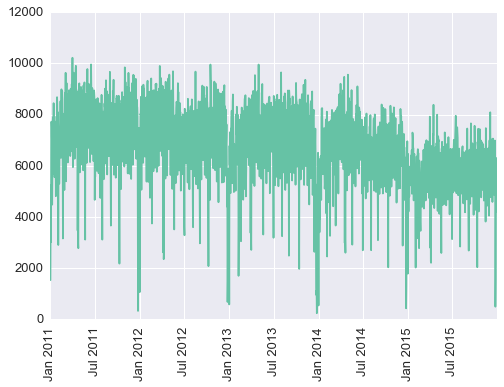

In [12]:
X = fines_per_day
plt.plot(X['date'],X['count'])
plt.xticks(rotation = 'vertical')

(array([ 734319.,  734503.,  734685.,  734869.,  735050.,  735234.,
         735415.,  735599.,  735780.]), <a list of 9 Text xticklabel objects>)

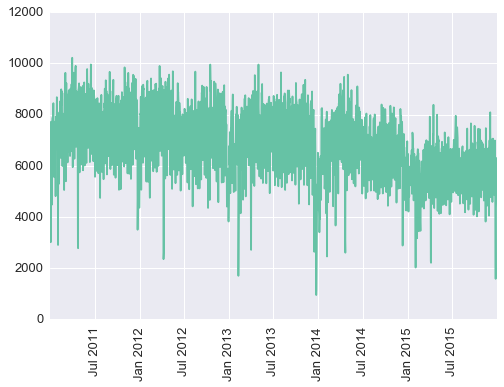

In [19]:
X = fines_per_day[fines_per_day['is_holiday'] == False]
plt.plot(X['date'],X['count'])
plt.xticks(rotation = 'vertical')

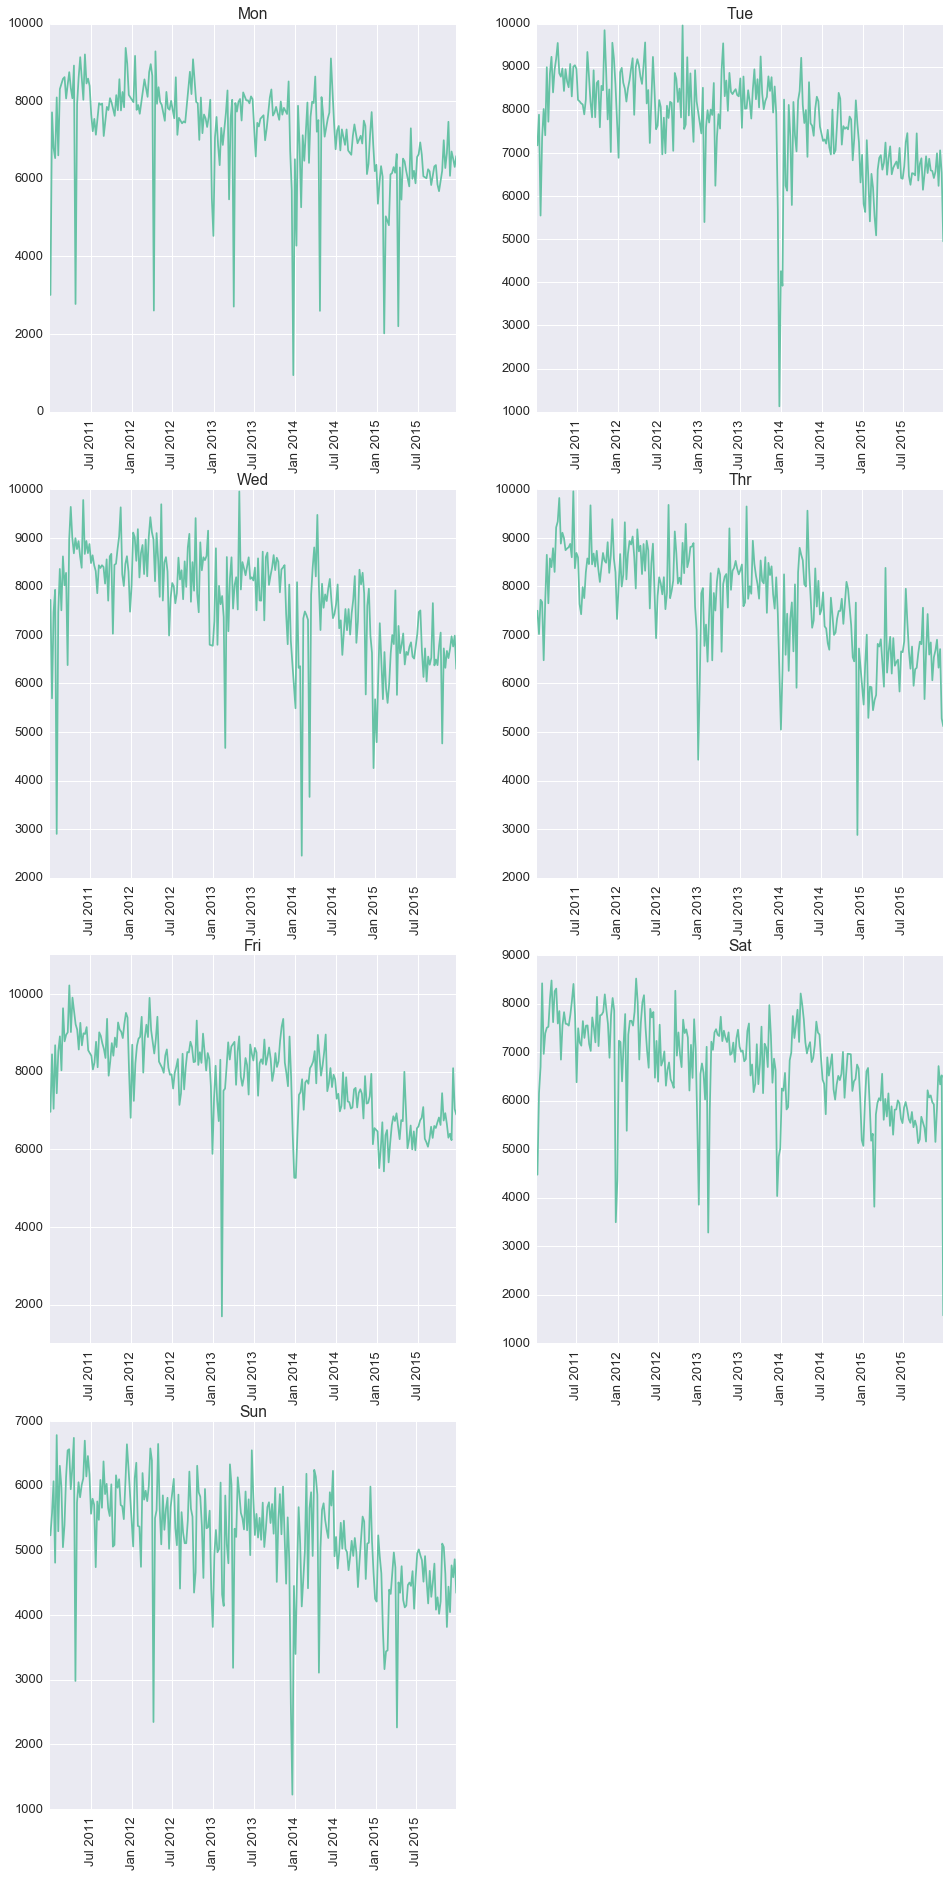

In [21]:
f = plt.figure(figsize=(16,32))
X1 = fines_per_day[fines_per_day['is_holiday']==False]
for i,day in enumerate(day_dict.values()):
    plt.subplot(4,2,i+1)
    plt.title(day)
    X = X1[X1['day_of_week'] == day]
    plt.plot(X['date'],X['count'])
    plt.xticks(rotation = 'vertical')

(array([ 734319.,  734503.,  734685.,  734869.,  735050.,  735234.,
         735415.,  735599.,  735780.]), <a list of 9 Text xticklabel objects>)

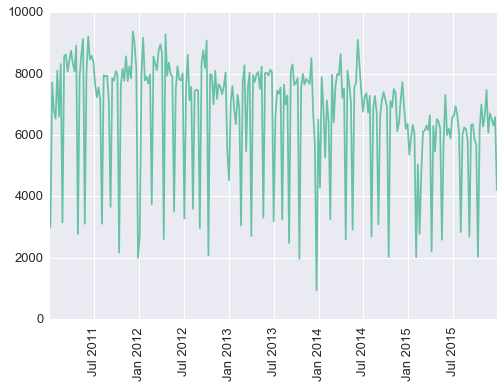

In [22]:
X = fines_per_day[fines_per_day['day_of_week'] == 'Mon']
plt.plot(X['date'],X['count'])
plt.xticks(rotation = 'vertical')

C:\Users\Todd\Anaconda2\lib\site-packages\pandas\computation\expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


(array([ 734319.,  734503.,  734685.,  734869.,  735050.,  735234.,
         735415.,  735599.,  735780.]), <a list of 9 Text xticklabel objects>)

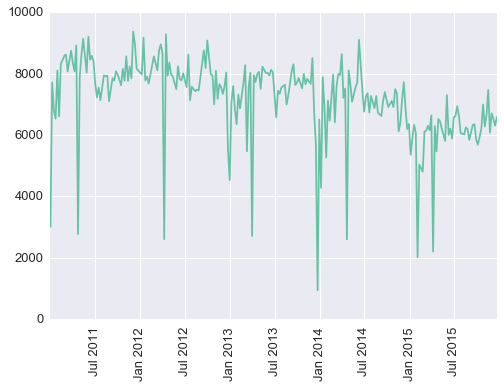

In [23]:
X = fines_per_day[(fines_per_day['day_of_week'] == 'Mon' )* (fines_per_day['is_holiday'] == False)]
plt.plot(X['date'],X['count'])
plt.xticks(rotation = 'vertical')

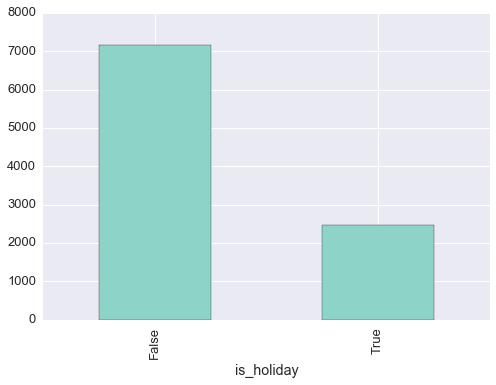

In [146]:
fines_per_day.groupby('is_holiday').mean()['count'].plot(kind='bar')

In [161]:
fines_per_day[fines_per_day['is_holiday']].groupby('day_of_week').count()['count']

day_of_week
Fri     8
Mon    30
Sat     1
Sun     3
Thr     3
Tue     4
Wed     4
Name: count, dtype: int64

# Holidays

### We will use a python library in order to pull ontario holidays for our models

In [14]:
import holidays
import datetime

In [15]:
holiday_list = []
for date, name in sorted(holidays.CA(state='ON', years = range(2011,2016)).items()):
    holiday_list.append(date)

In [16]:
datetime.date(2015,12,25) in holidays.Canada()

True

In [17]:
def is_holiday(date):
    for day in holiday_list:
        if date.date() == day:
            return True
    else:
        return False


fines_per_day['is_holiday'] = fines_per_day['date'].apply(is_holiday)

In [18]:
fines_per_day.head()

,count,sum,date,day_of_week,is_holiday
0,1527,83570,2011-01-01,Sat,True
1,5233,218885,2011-01-02,Sun,False
2,3009,121630,2011-01-03,Mon,False
3,7177,287470,2011-01-04,Tue,False
4,7722,318960,2011-01-05,Wed,False


# Machine Learning

In [24]:
import sklearn as sk
import numpy as np
from sklearn import linear_model

In [25]:
fines_per_day['x'] = (fines_per_day['date'] - min(fines_per_day['date']))/ np.timedelta64(1,'D')

In [26]:
linreg = linear_model.LinearRegression()

### We will fit a linear model for each day of the week

In [27]:
linregs = {}
for day in day_dict.values():
    linreg=linear_model.LinearRegression()
    linregs[day] = linreg
    plot_data = fines_per_day[(fines_per_day['day_of_week'] == day) *
                              (fines_per_day['date'] <= datetime.date(2014,12,31))]
    X = plot_data[['x']]
    y = plot_data['count']
    linreg.fit(X,y)
    

### Here is a plot of all Mondays and the linear regression model

(array([ 734319.,  734503.,  734685.,  734869.,  735050.,  735234.,
         735415.,  735599.,  735780.]), <a list of 9 Text xticklabel objects>)

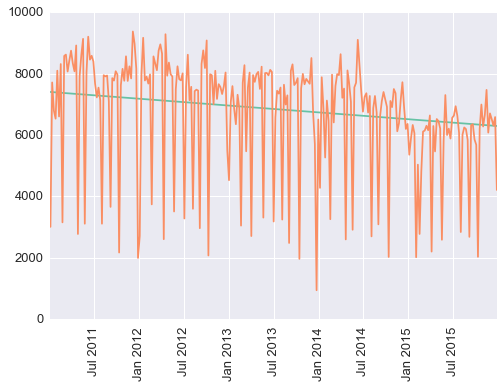

In [28]:
monday = fines_per_day[fines_per_day['day_of_week'] == 'Mon']
plt.plot(monday[['date']] , linregs['Mon'].predict(monday[['x']]))
plt.plot(monday[['date']] , monday[['count']])
plt.xticks(rotation = 'vertical')

In [29]:
linearreg = []
for el in fines_per_day.values:
    linearreg.append(linregs[el[3]].predict(el[5])[0])

In [30]:
residuals = []
for el in fines_per_day.values:
    residuals.append((el[0] - linregs[el[3]].predict(el[5])[0]) / linregs[el[3]].predict(el[5])[0])

In [31]:
fines_per_day['residuals'] = residuals
fines_per_day['linear model'] = linearreg

### Full model

(array([ 734138.,  734319.,  734503.,  734685.,  734869.,  735050.,
         735234.,  735415.,  735599.,  735780.]),
 <a list of 10 Text xticklabel objects>)

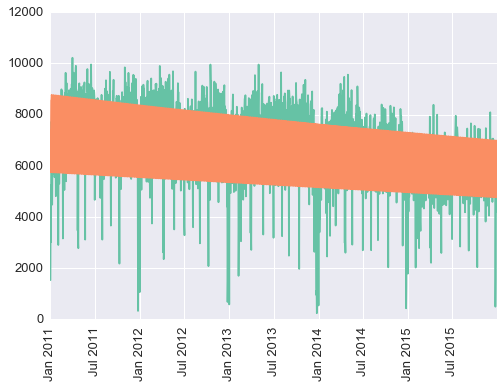

In [33]:
plt.plot(fines_per_day['date'] , fines_per_day['count'])
plt.plot(fines_per_day['date'] , fines_per_day['linear model'])
plt.xticks(rotation = 'vertical')

### Zooming in, we can see it is actually a fairly accurate model already

(array([ 735818.,  735832.,  735846.,  735860.,  735874.,  735888.]),
 <a list of 6 Text xticklabel objects>)

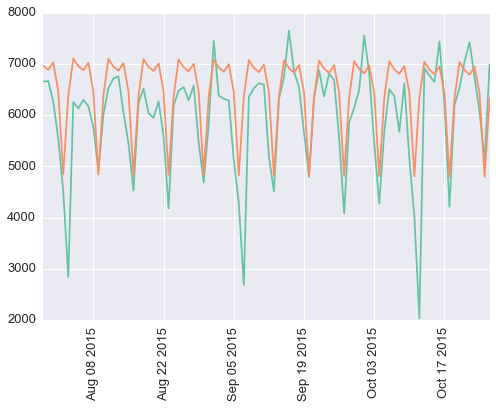

In [34]:
low = 365*4 + 30*7
high = low+90
plt.plot(fines_per_day['date'][low:high],fines_per_day['count'][low:high])
plt.plot(fines_per_day['date'][low:high],fines_per_day['linear model'][low:high])
plt.xticks(rotation = 'vertical')

### In order to improve the model, we will perform a linear regression on the residuals with the holidays as a feature

(array([ 734138.,  734319.,  734503.,  734685.,  734869.,  735050.,
         735234.,  735415.,  735599.,  735780.]),
 <a list of 10 Text xticklabel objects>)

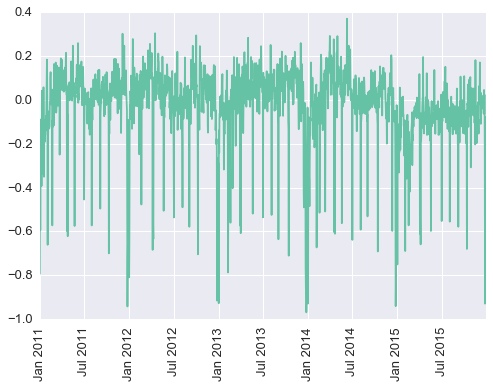

In [35]:
#plot of the residuals
low = 0
high = -1
plt.plot(fines_per_day['date'][low:high],fines_per_day['residuals'][low:high])
plt.xticks(rotation = 'vertical')

### We will "One-Hot Encode" the days of the week in order to better estimate the effect of holidays

In [36]:
le = sk.preprocessing.LabelEncoder()
ohe = sk.preprocessing.OneHotEncoder()

In [37]:
train = fines_per_day[fines_per_day['date'] <= datetime.date(2014,12,31)]
test = fines_per_day[fines_per_day['date'] > datetime.date(2014,12,31)]
labels = le.fit_transform(train['day_of_week'])
one_hot_days = ohe.fit_transform(labels.reshape(-1,1))
X_train = pd.DataFrame(one_hot_days.todense())
X_train['is_holiday'] = train['is_holiday'].apply(float)

labels = le.transform(test['day_of_week'])
one_hot_days = ohe.transform(labels.reshape(-1,1))
X_test = pd.DataFrame(one_hot_days.todense())
X_test['is_holiday'] = test.reset_index()['is_holiday'].apply(float)

labels = le.transform(fines_per_day['day_of_week'])
one_hot_days = ohe.transform(labels.reshape(-1,1))
both = pd.DataFrame(one_hot_days.todense())
both['is_holiday'] = fines_per_day.reset_index()['is_holiday'].apply(float)

In [38]:
print X_train.head()
print X_test.head()

     0    1    2    3    4    5    6  is_holiday
0  0.0  0.0  1.0  0.0  0.0  0.0  0.0         1.0
1  0.0  0.0  0.0  1.0  0.0  0.0  0.0         0.0
2  0.0  1.0  0.0  0.0  0.0  0.0  0.0         0.0
3  0.0  0.0  0.0  0.0  0.0  1.0  0.0         0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  1.0         0.0
     0    1    2    3    4    5    6  is_holiday
0  0.0  0.0  0.0  0.0  1.0  0.0  0.0         1.0
1  1.0  0.0  0.0  0.0  0.0  0.0  0.0         0.0
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0         0.0
3  0.0  0.0  0.0  1.0  0.0  0.0  0.0         0.0
4  0.0  1.0  0.0  0.0  0.0  0.0  0.0         0.0


In [39]:
linreg = sk.linear_model.LinearRegression()

In [40]:
holiday_model = linreg.fit(X_train,train['residuals'])

### A plot of the linear model for the residuals plotted along with the true residuals

(array([ 735814.,  735821.,  735828.,  735835.,  735842.,  735849.,
         735856.,  735863.]), <a list of 8 Text xticklabel objects>)

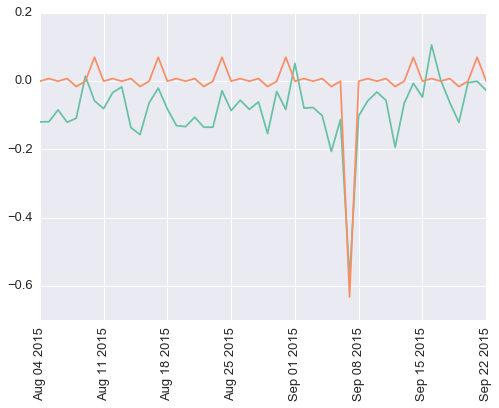

In [42]:
low = -150
high = -100

plt.plot(test['date'][low:high],test['residuals'][low:high])
plt.plot(test['date'][low:high],holiday_model.predict(X_test)[low:high])
plt.xticks(rotation = 'vertical')

In [43]:
fines_per_day['residual model'] = holiday_model.predict(both)

In [44]:
fines_per_day['holiday model'] = fines_per_day['linear model'] * (1 + fines_per_day['residual model'])

### The current model plotted with the true values

(array([ 735818.,  735832.,  735846.,  735860.,  735874.,  735888.]),
 <a list of 6 Text xticklabel objects>)

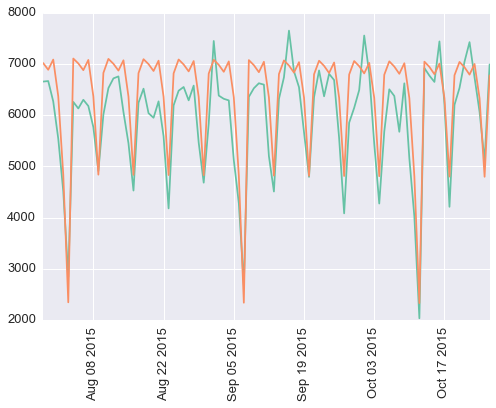

In [45]:
low = 365*4 + 30*7
high = low+90

#plt.plot(fines_per_day['date'][low:high],fines_per_day['linear model'][low:high])
plt.plot(fines_per_day['date'][low:high],fines_per_day['count'][low:high])
plt.plot(fines_per_day['date'][low:high],fines_per_day['holiday model'][low:high])
plt.xticks(rotation = 'vertical')

### The residuals are roughly Gaussian, we can simulate noise in order to emulate (simulate) parking infraction data

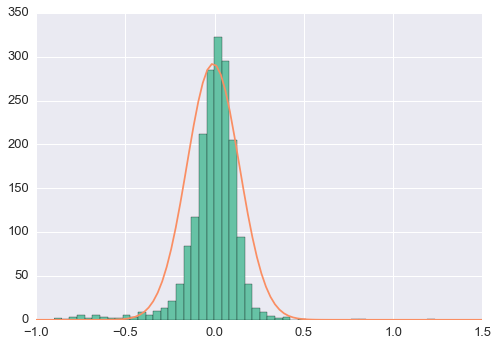

In [60]:
plt.hist(fines_per_day['holiday residual'],bins=50)
plt.plot(np.linspace(-1,1.5,100),np.sqrt(len(fines_per_day))/np.sqrt(hol_res_std**2)*np.exp(
        -(np.linspace(-1,1.5,100) - hol_res_mean)**2 / (2 * hol_res_std**2)))

In [47]:
fines_per_day['holiday residual'] = (fines_per_day['count'] - fines_per_day['holiday model']) / fines_per_day['holiday model']

In [48]:
hol_res_mean = fines_per_day['holiday residual'].mean()
hol_res_std = fines_per_day['holiday residual'].std()

In [49]:
np.random.seed(42)
fines_per_day['gaussian'] = np.random.normal(hol_res_mean,hol_res_std,len(fines_per_day))
fines_per_day['noise model'] = fines_per_day['holiday model'] * (1+ fines_per_day['gaussian'])

### Can you tell which plot is the real data, and which is the linear model?

(array([ 735818.,  735832.,  735846.,  735860.,  735874.,  735888.]),
 <a list of 6 Text xticklabel objects>)

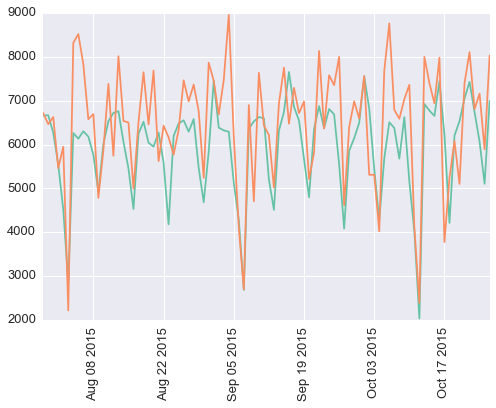

In [50]:
low = 365*4 + 30*7
high = low+90

#plt.plot(fines_per_day['date'][low:high],fines_per_day['linear model'][low:high])
plt.plot(fines_per_day['date'][low:high],fines_per_day['count'][low:high])
plt.plot(fines_per_day['date'][low:high],fines_per_day['noise model'][low:high])
plt.xticks(rotation = 'vertical')